# import packages

In [1]:
import pyspark
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chart_studio.plotly as py

# Config spark envir

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.hadoop:hadoop-aws:3.3.1" pyspark-shell'

In [3]:
sc = pyspark.SparkContext.getOrCreate()

:: loading settings :: url = jar:file:/Users/mac/opt/anaconda3/envs/DistributedComputing/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/mac/.ivy2/cache
The jars for the packages stored in: /Users/mac/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-60844774-38d5-4d3b-b914-4123aede0a77;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 184ms :: artifacts dl 6ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	-------------------------------------

In [4]:
hadoopConf = sc._jsc.hadoopConfiguration()
sc._jsc.hadoopConfiguration().set("fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', os.environ['AWS_ACCESS_KEY_ID'])
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', os.environ['AWS_SECRET_ACCESS_KEY'])

# read in data

In [5]:
# read in the whole data
rdd = sc.textFile("s3://usf-msds694-openpayments/BigSets/OP_DTL_GNRL_PGYR2019_P06302021.csv")

In [7]:
# extract the header
header = rdd.first().split(",")

21/12/05 00:52:01 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [ ]:
# create a header dict that can help us find the corresponding index
header_dict = dict()
for i, h in enumerate(header):
    header_dict[h] = i

In [9]:
# sample out tiny data for exploration
tiny_data = rdd.sample(False, 0.00002)

In [10]:
# change the tiny data to list rdd
import re
COMMA_MATCHER = re.compile(r",(?=(?:[^\"']*[\"'][^\"']*[\"'])*[^\"']*$)")
list_rdd = tiny_data.map(lambda x: COMMA_MATCHER.split(x))

In [ ]:
# store list_rdd in memory
list_rdd.cache()

In [106]:
# convert tiny data to pandas for EDA
df = pd.DataFrame(list_rdd.collect(), columns=header)
df.head()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,...,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date
0,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""100507""","""LISA""",,"""FORTMAN""",,...,,,,,,,,,"""2019""","""06/30/2021"""
1,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""91839""","""EDWARD""","""B""","""FERRER""",,...,,,,,,,,,"""2019""","""06/30/2021"""
2,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""2420242""","""CHARLES""","""T""","""CRELLIN""",,...,,,,,,,,,"""2019""","""06/30/2021"""
3,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""129829""","""BRENDA""","""LEE""","""SALINAS""",,...,,,,,,,,,"""2019""","""06/30/2021"""
4,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""5703828""","""ERIC""","""W""","""SCHWELLER""",,...,,,,,,,,,"""2019""","""06/30/2021"""


# exploration on tiny dataset

In [108]:
# let's check unique values in the data
for h in header:
    print(h + '---' + str(df[h].unique()))

Change_Type---['"UNCHANGED"' '"CHANGED"' '"NEW"'
 '"UNCHANGED","Covered Recipient Physician",,,,"1392554","TARIQ","S","HAKKY",,"371 E PACES FERRY ROAD","SUITE 550","ATLANTA","GA","30305","United States",,,"Medical Doctor","Allopathic & Osteopathic Physicians|Urology","GA",,,,,"Coloplast Corp","100000011212","Coloplast Corp","MN","United States",104.14,"03/20/2019","1","Cash or cash equivalent","Travel and Lodging","MINNEAPOLIS","MN","United States","No","No Third Party Payment",,,,"Residents and Fellows\' SSW"']
Covered_Recipient_Type---['"Covered Recipient Physician"' '"No"'
 '"Covered Recipient Teaching Hospital"']
Teaching_Hospital_CCN---['' '"696961053"' '"010033"']
Teaching_Hospital_ID---['' '"No"' '"8241"']
Teaching_Hospital_Name---['' '"Yes"' '"UNIVERSITY OF ALABAMA HOSPITAL"']
Physician_Profile_ID---['"100507"' '"91839"' '"2420242"' '"129829"' '"5703828"' '"120824"'
 '"639573"' '"39538"' '"964939"' '"329034"' '"1098448"' '"341690"'
 '"127664"' '"267724"' '"186473"' '"237063"' '

TypeError: 'value' must be an instance of str or bytes, not a None

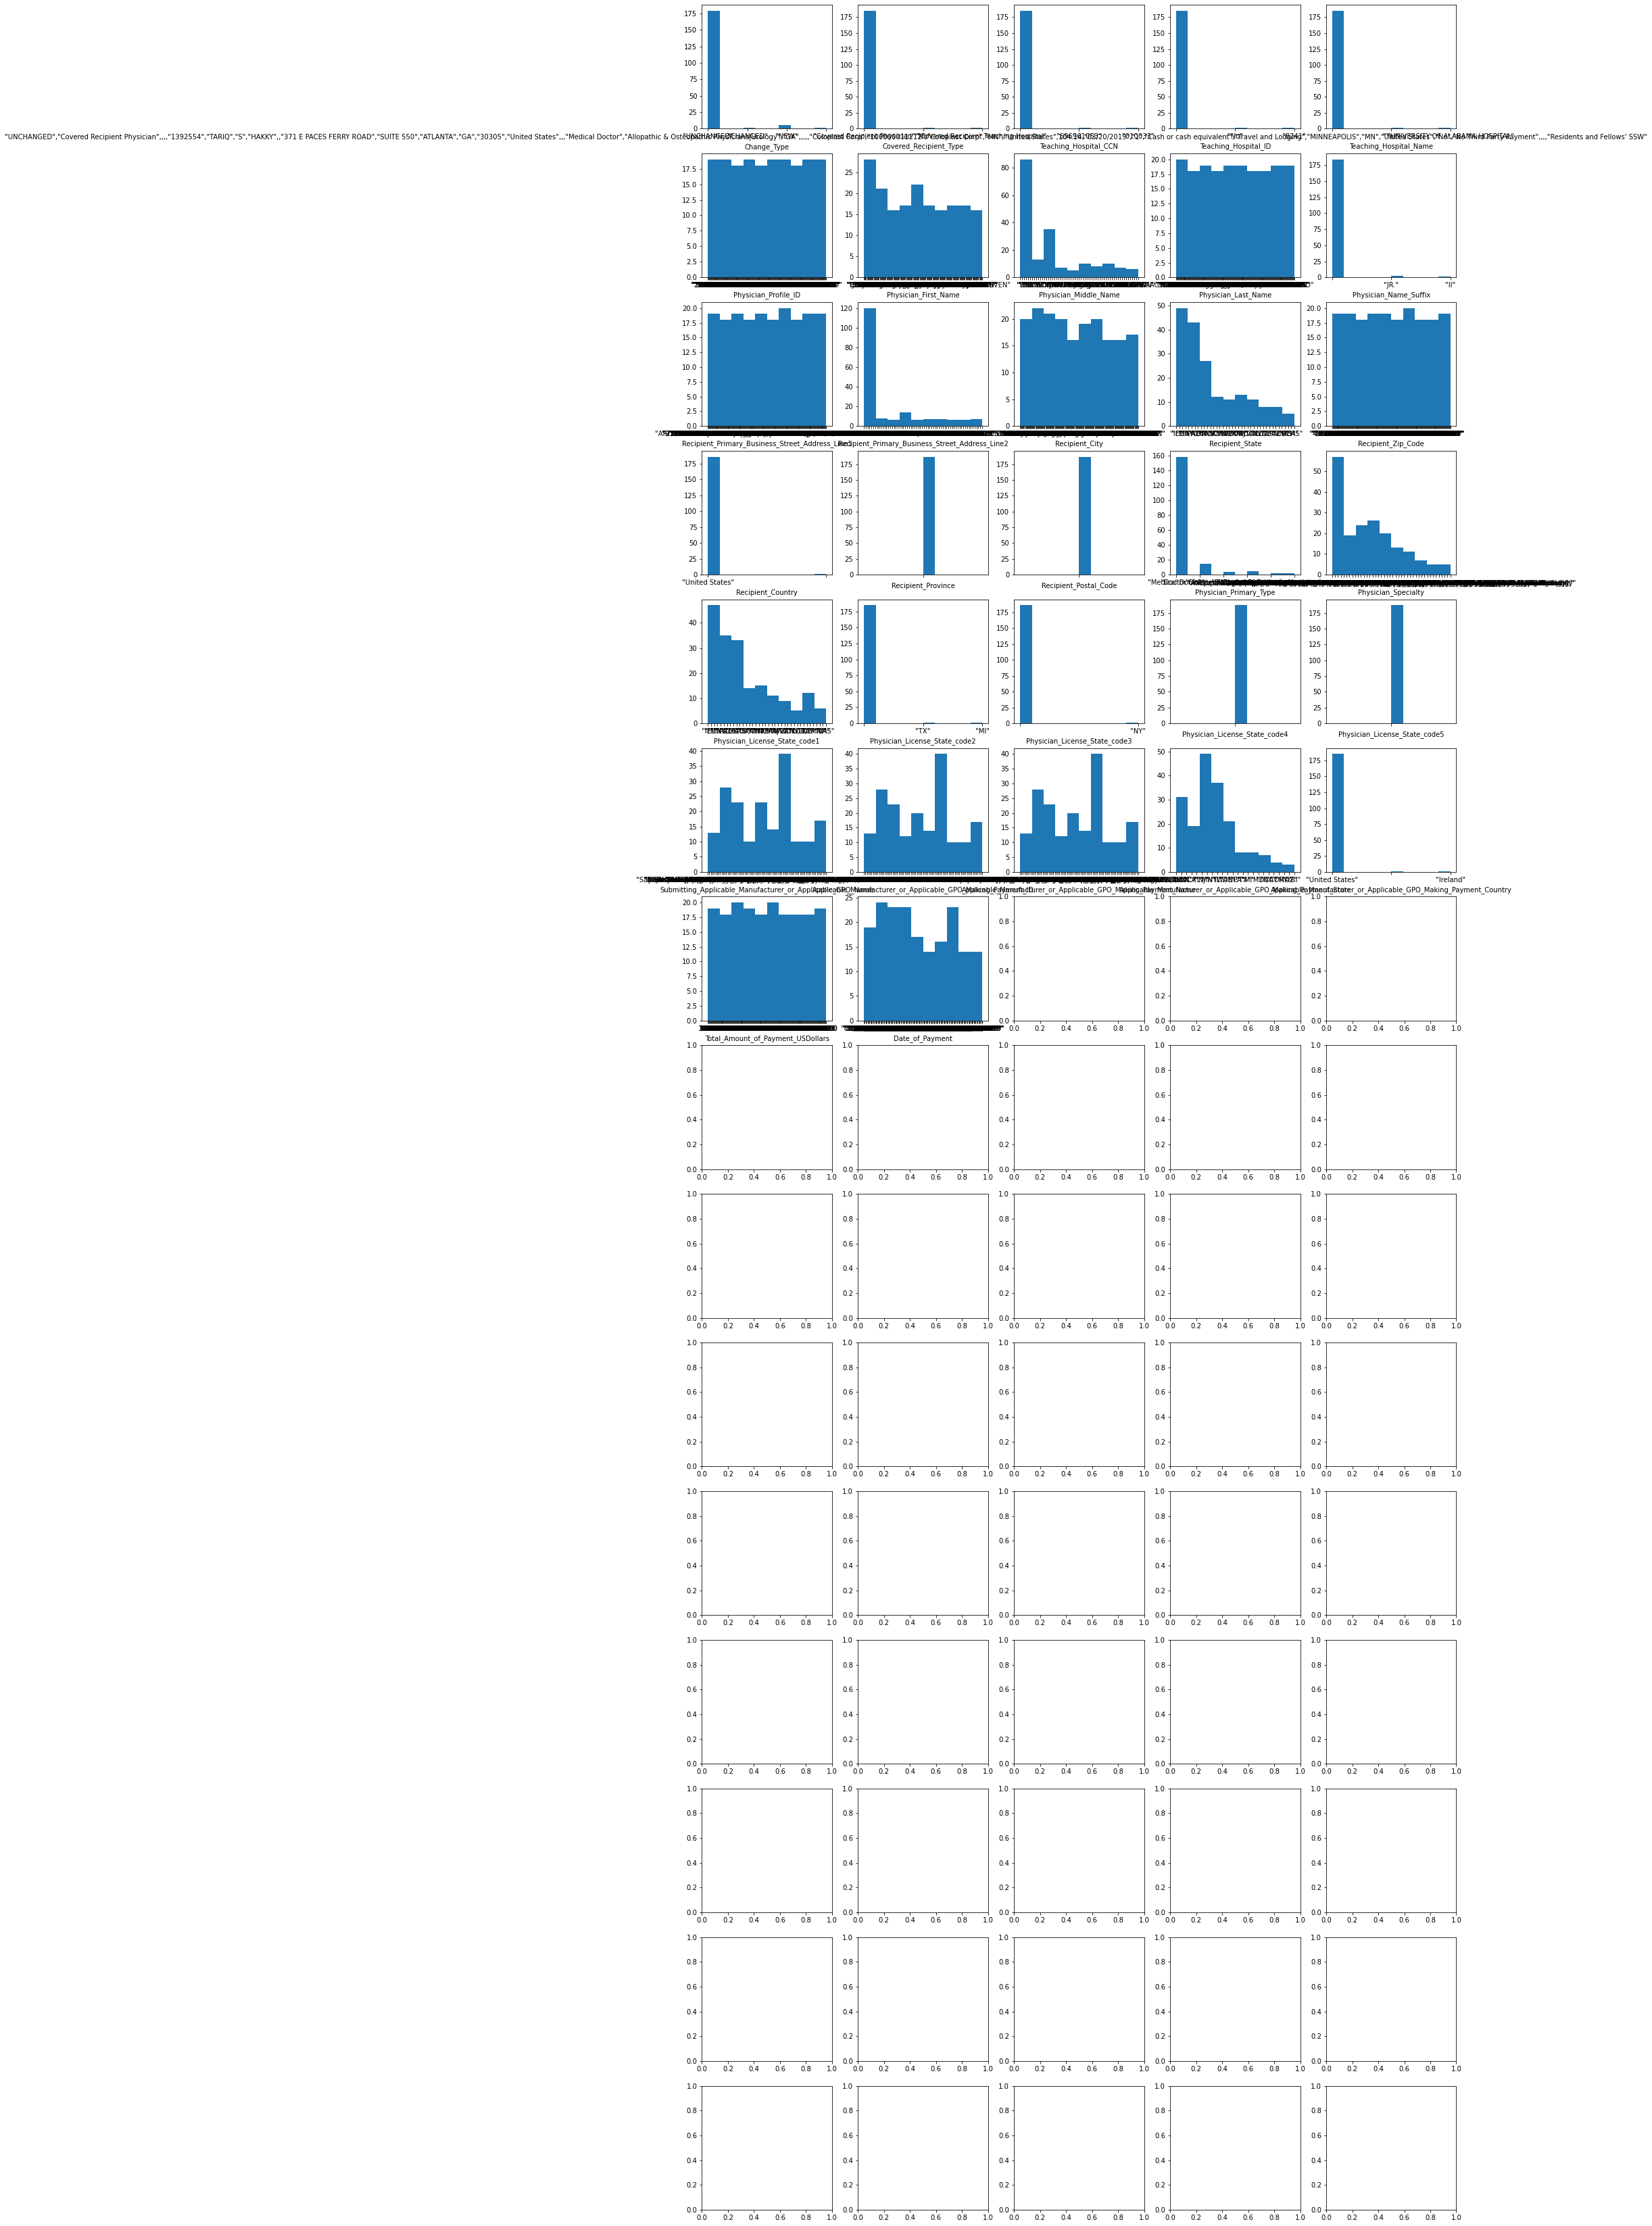

In [111]:
# after checking the unique values, we find the first 5 and last 20 do only have one value, so we skip them
figure, axis = plt.subplots(15, 5, figsize =(20, 60))
ax = axis.flatten()
for i in range(75):
    ax[i].hist(df[header[i]])
    ax[i].set_xlabel(header[i])

# Basic visualization

In [60]:
import plotly.express as px
import plotly.graph_objects as go

### recipient state against total amount of payment

In [53]:
# I am interested in recipient state and total amount of payment, let's take a look
payment_per_state = list_rdd.map(lambda x: (x[13].replace('"',""), float(x[30].replace('"',""))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [56]:
# convert to dataframe
payment_per_state_df = pd.DataFrame(payment_per_state.collect(), columns=['state', 'amount'])
payment_per_state_df.head()

,state,amount
0,AL,30076.71
1,CT,2853.42
2,CO,2447.95
3,NY,2332.55
4,CA,2157.28


In [148]:
# plot
fig1 = px.histogram(payment_per_state_df, x='state', y='amount')
fig1.show()

In [149]:
# Since it is state data, a map plot might be better
fig2 = go.Figure(data=go.Choropleth(
    locations=payment_per_state_df['state'], # Spatial coordinates
    z = payment_per_state_df['amount'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "dollar",
))

fig2.update_layout(
    title_text = 'Payment Received Per State',
    geo_scope='usa', # limite map scope to USA
)

fig2.show()

### Physician against amount

In [91]:
# I am interested in what type of Physician gets most
payment_per_physician_type = list_rdd.map(lambda x: (x[18].replace('"',""), float(x[30].replace('"',""))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [92]:
# convert to dataframe
payment_per_physician_type_df = pd.DataFrame(payment_per_physician_type.collect(), columns=['physician_type', 'amount'])
payment_per_physician_type_df.head()

,physician_type,amount
0,,32019.00
1,Medical Doctor,15982.24
2,Doctor of Dentistry,1499.57
3,Doctor of Osteopathy,797.25
4,Doctor of Optometry,329.58


In [150]:
# plot
fig3 = px.histogram(payment_per_physician_type_df, x='physician_type', y='amount')
fig3.show()

### specialities against amount

In [114]:
# I am interested in what type of specialities gets most
payment_per_speciality_type = list_rdd.map(lambda x: (x[19].replace('"',""), float(x[30].replace('"',""))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [115]:
# convert to dataframe
payment_per_speciality_type_df = pd.DataFrame(payment_per_speciality_type.collect(), columns=['Physician_Specialty', 'amount'])
payment_per_speciality_type_df.head()

,Physician_Specialty,amount
0,,32019.00
1,Allopathic & Osteopathic Physicians|Internal M...,4372.78
2,Allopathic & Osteopathic Physicians|Pediatrics...,2800.00
3,Allopathic & Osteopathic Physicians|Psychiatry...,2066.04
4,Allopathic & Osteopathic Physicians|Internal M...,1636.32


In [203]:
# plot
fig4 = px.histogram(payment_per_speciality_type_df.iloc[1:,], x='Physician_Specialty', y='amount')
fig4.show()

### use information of two files

In [160]:
# read in the whole data
rdd2 = sc.textFile("s3://usf-msds694-openpayments/BigSets/MUP_DPR_RY21_P04_V10_DY19_NPIBN_1.csv")
# sample out tiny data
tiny_data_2 = rdd2.sample(False, 0.00002)
tiny_data_2.cache()

PythonRDD[368] at RDD at PythonRDD.scala:53

In [161]:
header2 = rdd2.first().split(",")
header2
header2_dict = dict()
for i, h in enumerate(header2):
    header2_dict[h] = i

In [162]:
# change the tiny data 2 to list rdd
list_rdd_2 = tiny_data_2.map(lambda x: COMMA_MATCHER.split(x))

In [ ]:
# I am guessing the state that received more payment will have a larger drug cost
cost_per_state = list_rdd_2.map(lambda x: (x[4], float(x[13].replace('','0'))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [196]:
payment_cost_per_state = payment_per_state.leftOuterJoin(cost_per_state).map(lambda x: [x[0], x[1][0], x[1][1]])

In [199]:
# convert to dataframe
payment_cost_per_state_df = pd.DataFrame(payment_cost_per_state.collect(), columns=['state', 'payment_amount','drug_cost'])
payment_cost_per_state_df.head()

,state,payment_amount,drug_cost
0,,2019.00,NaN
1,OK,5.09,1.109304e+10
2,AR,154.83,9.192234e+07
3,MS,10.86,1.934244e+08
4,PA,663.37,2.280197e+09


In [200]:
# plot
fig5 = px.scatter(payment_cost_per_state_df, x="payment_amount", y="drug_cost")
fig5.show()

# make html file with all plots

In [205]:
with open('graphs.html', 'w') as f:
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig4.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig5.to_html(full_html=False, include_plotlyjs='cdn'))

In [38]:
# stop instance
sc.stop()